# Natural sequences

## Introduction to SeqDEFT

Many times, rather than quantitative measurements of a phenotype or trait for a large collection of sequences, we just have observations of natural sequences, e.g. 5' splice sites in the human transcriptome or combinations of chromosomal abnormalities in tumors (See [Chen et al. 2022](https://www.pnas.org/doi/10.1073/pnas.2025782118) for more details). In this case, we are interested in estimating the true underlying probability of each of the possible sequences using only a finite number of observations. This number of observations, that typically ranges from few hundreds to tens or hundreds of thousands, is so that the observed frequencies are very poor estimators of the true underlying probability distribution. This is exemplified by the fact that a substantial fraction of all possible sequences are not even present in the finite sample even if they occure with a non-zero true probability

### Maximum entropy sequence probability distributions

A simple model would assume that positions are independent from each other, and thus, we can recapitulate the full sequence probability distribution from the site-wise allele probabilities. This is because if two positions are independent, then the probability of observing a particular combination at 2 sites is equal to the product of the individual probabilities at each site or, equivalently, the log-probability of the combination is the sum of the log-probabilities of the alleles at each position. 

$$p(AB) = p(A) p(B)$$

$$log(p(AB)) = log(p(A)) + log(p(B))$$

Thus, we can represent the probability of distribution of sequences of certain length using a field $\Phi$ as follows and show that the field is just a shifted version of the negative $\log Q$:

$$Q_i = \frac{e^{-\Phi_i}}{\sum_j e^{-\Phi_j}}$$

$$\log Q_i = -\Phi_i - \log\left({\sum_j e^{-\Phi_j}}\right) = -\Phi_i - C$$

Thus, independent sites models can be generally represented by additive models on the log-transformed probabilities. These models can be generalized by adding pairwise interaction terms like in the Potts model, which have been very succesful for contact prediction and identifying coevolving residues within or between different proteins (See [Stein et al. 2015](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004182) for an example). They could in principle be further extended in the same way to include higher order components up to $P$'th. 

All these models belong to the class of maximum entropy models, this is, models that maximize the entropy of the underlying distribution given some constraints. These constraints typically consist on matching the lower order marginals of the data i.e. allele frequencies in the site independens model; frequencies of subsequences at pairs of sites across the whole sequence. While maximizing the entropy provides the simplest possible model that has the desired properties, by doing so it also neglect the existance of interactions beyond the $P$'th order.

### Relaxing maximum entropy assumption: the $\Delta^{(P)}$ prior

SeqDEFT relaxes the maximum entropy assumption by instead minimizing the magnitude of the deviations in the field $\Phi$ from the additive, pairwise, or in general, $P-1$ order model across all $P$-faces of the Hamming hypercube. The strength of this penalization is given by the hyperparameter $a$. This is equivalent to imposing a normal prior on the the local $P$-epistatic coefficients $\epsilon_P$'s while conditioning on them being compatible with each other. In particular, for $P=2$, we minimize the local deviations from a simple additive model or local pairwise epistatic coefficients $\epsilon_{2}$ without forcing them to be 0 as assumed by Maximum Entropy models. 

$$\epsilon_{2} = (\Phi_{11} - \Phi_{10}) - (\Phi_{01} - \Phi_{00}) = \Phi_{11} + \Phi_{00} - \Phi_{01} - \Phi_{10}$$

In this case, we are setting a normal prior on the local pairwise epistatic coefficients, where the variance is inversely related to the hyperparameter $a$, $\kappa$ is the dimension of the unpenalized space comprising up to $P-1$'th order interactions, $\alpha$ the number of alleles and $\ell$ the sequence length.

$$\epsilon \sim Normal\left(0, \sigma^2\right)$$
$$\sigma^2 = \frac{\alpha^\ell-\kappa}{a}$$

Note that this allows the $P$-epistatic coefficients to differ across distinct genetic backgrounds in a controled manner, allowing higher order interactions in regions of sequence space where there is strong evidence for them but being closer to the maximum entropy model in regions of sequence space where the data is more scarce. From a different point of view, we are smoothing the $\log Q$ over sequence space by limiting the magnitude of these local interaction coefficients across the whole sequence space.

### The likelihood

Our model assumes a multinomial likelihood with $\alpha^\ell$ categories corresponding to all possible sequences of length $\ell$ with $\alpha$ alleles given a total number of observations $N$.

$$n \sim Multinomial(N, Q)$$

<div class="alert alert-block alert-info"><b>Note:</b> This implies that observed sequences are considered completely independent draws from the same probability distribution, an assumption that is sometimes violated in nature e.g. due to common ancestry or phylogenetic relationships between observed sequences. </div>

### Hyperparameter optimization

We optimize $a$ using cross-validation and select the $a^*$ that maximizes log-likelihood in held out data. In practice, we need to define a finite series of $a$ values, which we know interpolate between the maximum entropy solution of order $P$ (where all these deviations are exactly 0) and the observed empirical frequencies for each of the sequences, which are strongly influenced by finite sampling and noise. Thus, we generate a geometrically spaced series of $a$ values between $a_{min}$, which is very close to the empirical frequencies, and $a_{max}$, a value that is very close to the maximum entropy solution, both of which we can compute in a more straighforward manner. This allows us to generate a 1-dimensional family of models that interpolate between the two extremes, allowing but limiting local deviations from the $P-1$'th order model.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gpmap.plot.mpl as plot

from scipy.special import logsumexp
from scipy.stats import pearsonr
from gpmap.inference import SeqDEFT
from gpmap.seq import calc_msa_weights, get_subsequences
from gpmap.space import SequenceSpace
from gpmap.randwalk import WMWalk
from gpmap.datasets import DataSet

## Inference from simulated data

### How to sample from the prior distribution

For illustration purposes, lets first sample a complete landscape by generating a sequence probability distribution from the prior distribution characterzed by `a=500` and `P=2`. 

In [2]:
np.random.seed(1)
model = SeqDEFT(P=2, seq_length=5, alphabet_type="dna", a=500)
phi = model.simulate_phi()

We will assume that the simulated values are the $\Phi$ values for each sequence and then sample a small number of observations from the resulting probability distribution and show the values for some of the sequences.

In [3]:
X = model.simulate(N=1000, phi=phi)
X_unique, counts = np.unique(X, return_counts=True)
print("{:.2f} % of possible genotypes observed at least once".format(X_unique.shape[0] / model.n_genotypes * 100))

50.39 % of possible genotypes observed at least once


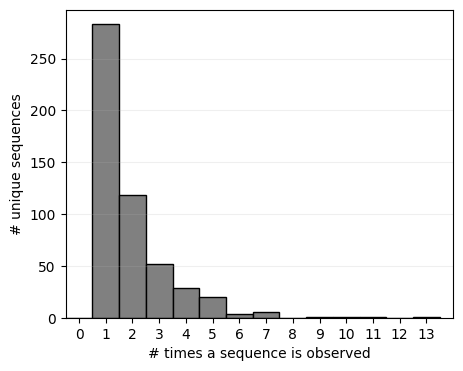

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
freq, c = np.histogram(counts,  bins=np.arange(max(counts) + 2))
axes.bar(c[:-1], freq, color='grey', lw=1, edgecolor='black', width=1)
axes.set(xlabel='# times a sequence is observed', ylabel='# unique sequences',
         xlim=(-0.5, max(counts) + 1), xticks=np.arange(max(counts) + 1))
axes.grid(alpha=0.2, axis='y')

Note that about half of the possible sequences are not even observed once when sampling up to 1000 sequences, and only very few are observed more than once. While this evidences that their probability is probably lower than the highly observed sequences, there is still a wide range of variability in the sequence probability below the observable threshold that we may be able to infer by sharing information across sequence space.

### How to infer the probability distribution

Lets initialize again our SeqDEFT model with `P=2` and infer the sequence probability distribution underlying the finite set of observed sequences in nature

In [5]:
model = SeqDEFT(P=2, seq_length=5, alphabet_type="dna")
inferred = model.fit(X=X)

100%|██████████| 115/115 [00:01<00:00, 73.36it/s]


We can see that even for a small example of 5 nucleotides long sequence spanning only $4^5=1024$ possible genotypes, iterating through all the cross-validation folds for each $a$ value takes a substatial amount of time. For larger genotypic spaces, however, one could paralellize these calculations by defining the training and testing datasets for the cross-validation and fit the model with different $a$ values at the same time.

Lets see how the log-likelihood in held-out data evolves with the different values of the hyperparameter $a$ tested.

In [6]:
model.logL_df

,a,fold,logL,log_a,sd,log_sd
0,inf,0,-550.279911,inf,0.000000,-inf
1,0.000000e+00,0,-inf,-inf,inf,inf
2,2.304000e-02,0,-885.230603,-1.637518,1000.000000,3.000000
3,4.767294e-02,0,-850.328246,-1.321728,695.192796,2.842105
4,9.864190e-02,0,-812.810634,-1.005939,483.293024,2.684211
...,...,...,...,...,...,...
110,2.600843e+03,4,-531.134202,3.415114,2.976351,0.473684
111,5.381502e+03,4,-540.013112,3.730904,2.069138,0.315789
112,1.113507e+04,4,-546.699369,4.046693,1.438450,0.157895
113,2.304000e+04,4,-550.805156,4.362482,1.000000,0.000000


In [7]:
print('a*={}'.format(model.a))

a*=607.4843670674737


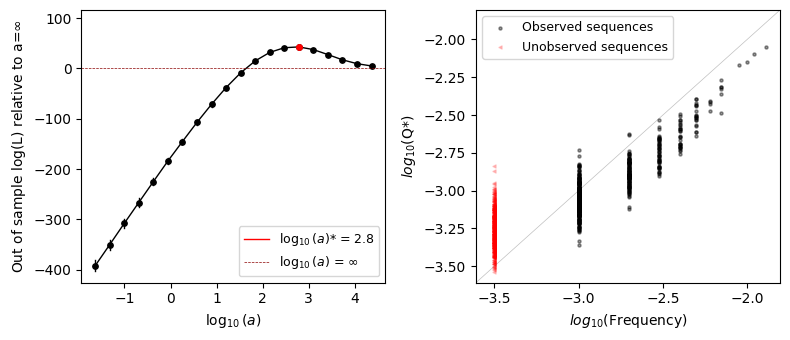

In [8]:
fig = plot.plot_SeqDEFT_summary(model.logL_df, inferred, legend_loc=4)

 We can see that the optimal value $a^*$ is far from 0 but also is not $\infty$ either and close to the true generating $a_{True}=500$, showing that the optimal solution is indeed somewhere in between the maximum entropy solution and the empirical frequencies. In this case, we chose $a$ to have relatively small deviation from the additive model, so that the cross-validated likelihood in the case $a=\infty$ is close to that under $a^*$

The second plot shows the relationship between the observed frequencies in the data and the inferred probabilities for each of the genotypes. For high frequencies, we generally see a very good agreement between the observed frequencies and inferred probabilities. However, as we start to have lower number of counts per sequence, we can see how the prior becomes more and more important. In fact, the sequences with lowest frequency, those never observed or only once, show substantial variability in the inferred densities thanks to our ability to share information across neighboring sequences and smooth the log-probabilities over sequence space.

Note that we are also plotting sequences with 0-counts in red and with a different marker at an arbitrary position in the x-axis. We can see that the inferred probabilities are in average lower than for those sequences with 1 count, but both sets of sequences show a large spread when compared to that difference. This means that, at least in this case, observing a sequence alone does not provide such a strong evidence of functionality as compared with unobserved sequences. 

### Evaluating the inferred probability distributions

In this case, as the data was simulated, we can see good our estimates of the sequence density were by comparing with the true data generating probabilities

In [9]:
inferred['Q_true'] = np.exp(- phi - logsumexp(phi))
inferred

,frequency,phi,Q_star,Q_true
AAAAA,0.000,7.232449,0.000723,0.000631
AAAAC,0.001,7.126278,0.000804,0.000629
AAAAG,0.000,7.187344,0.000756,0.000376
AAAAT,0.001,7.294846,0.000679,0.000999
AAACA,0.000,7.398920,0.000612,0.000846
...,...,...,...,...
TTTGT,0.000,7.397642,0.000613,0.000371
TTTTA,0.000,7.509691,0.000548,0.000275
TTTTC,0.000,7.196643,0.000749,0.000815
TTTTG,0.001,6.589644,0.001375,0.003237


Text(0.05, 0.95, '$R^2$=0.46')

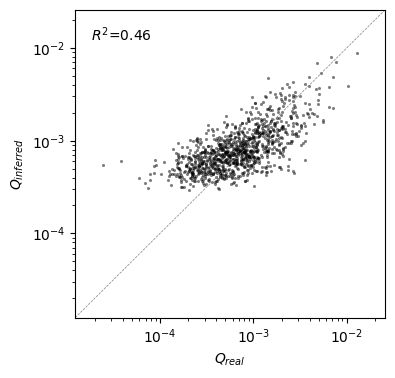

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True)

Q = inferred[['Q_true', 'Q_star']].values.flatten()
lims = (Q.min()/2, Q.max()*2)
axes.scatter(inferred['Q_true'], inferred['Q_star'], s=5, c='black', alpha=0.5, lw=0)
axes.plot(lims, lims, lw=0.5, linestyle='--', c='grey')
axes.set(xlabel=r'$Q_{real}$', ylabel=r'$Q_{inferred}$',
         xscale='log', yscale='log',
         xlim=lims, ylim=lims)

r2 = pearsonr(np.log(inferred['Q_true']), np.log(inferred['Q_star']))[0] **2
axes.text(0.05, 0.95, '$R^2$={:.2f}'.format(r2), transform=axes.transAxes,
          ha='left', va='top')

We can see that even for sequences with low density, such that they  would almost never be observed in practice by sampling only 1000 genotypes from this distribution, SeqDEFT provides a moderately good estimate of the sequence density. While it tends to overestimate the density of very rare sequences, it still provides a good idea of which sequences have higher or lower probability.

### Main features of the probability distribution

But maybe a more important issue rather than the precission with which we can estimate the sequence probability is whether we are able to recover the main qualitative features of the original landscape from the simulated data. Thus, we can compare the visualizations for both the real and the estimated $\log Q$ as follows:

In [11]:
space_real = SequenceSpace(X=inferred.index.values, y=np.log10(inferred['Q_true']))
space_inferred = SequenceSpace(X=inferred.index.values, y=np.log10(inferred['Q_star']))
spaces = {'real': space_real, 'inferred': space_inferred}

### How to visualize a probability distribution

When trying to visualize densities rather than an arbitrary function or phenotype over sequence space, it provides a very natural way of setting the hyperparameter ``Ns``, since we can assume that the observed densities correspond to the stationary frequencies under our evolutionary model. As we saw previously, the stationary frequencies are given by:

$$\pi_i = \frac{e^{Ns f_i}}{\sum_j e^{Ns f_j}}$$

Thus, if we assume that $f_i = \log Q_i$, then we can choose ``Ns=1`` and:

$$\pi_i = \frac{e^{\log Q_i}}{\sum_j e^{\log Q_j}} = Q_i$$

This way, differences in $\log Q$ between two genotypes correspond to the scaled selection coefficient between them $S_{ij}$, and provides a natural scale for interpreting differences e.g. for $S_{ij}\sim1$ evolution would be nearly neutral and those mutations would fix very frequently.


In [12]:
viz = {}
for label, space in spaces.items():
    rw = WMWalk(space)
    rw.calc_visualization(Ns=1, n_components=5)
    nodes_df, edges_df = rw.nodes_df, rw.space.get_edges_df()
    viz[label] = nodes_df, edges_df

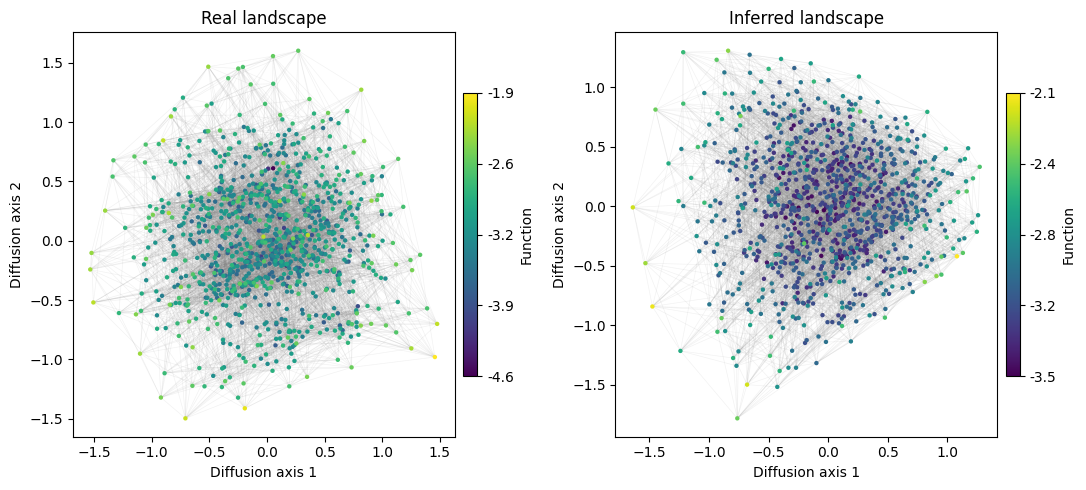

In [13]:
fig, subplots = plot.init_fig(1, len(spaces), colsize=5.5, rowsize=5)

for axes, (label, (nodes_df, edges_df)) in zip(subplots, viz.items()):
    plot.plot_visualization(axes, nodes_df, edges_df=edges_df, nodes_size=10)
    axes.set_title('{} landscape'.format(label.capitalize()))

fig.tight_layout()

It seems that the structure of the two landscapes is similar, but it is unclear from the plots whether the most separated set of sequences are the same in the two plots. We can instead show how the coordinates in the different diffusion axis correlate across the two embeddings

Text(0.02, 0.52, 'Inferred landscape')

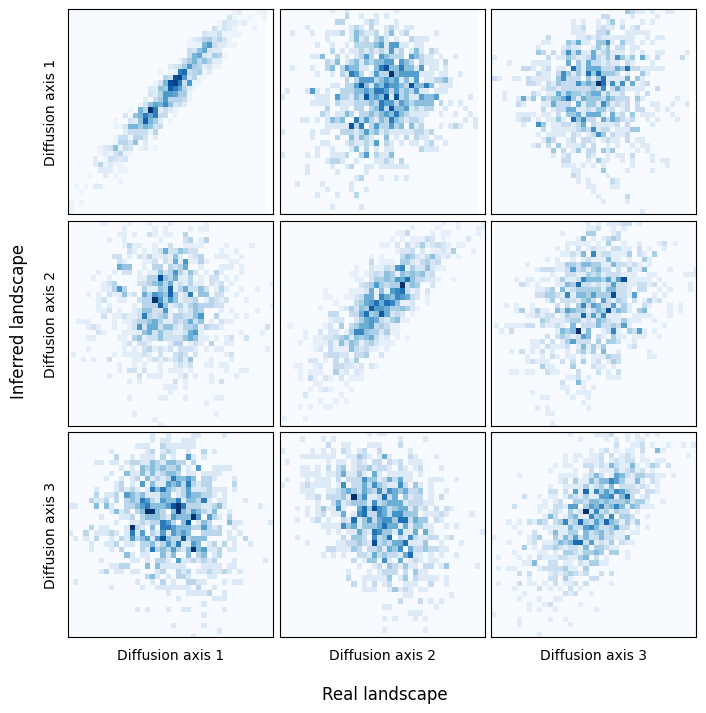

In [14]:
fig, subplots = plot.init_fig(3, 3, colsize=2.5, rowsize=2.5, sharex=True, sharey=True)
for i in range(3):
    for j in range(3):
        axes = subplots[i, j]
        x, y = viz['real'][0][str(i+1)].values, viz['inferred'][0][str(j+1)].values
        axes.hist2d(x=x, y=y, cmap='Blues', bins=40)
        axes.set(xlabel='', ylabel='', xticks=[], yticks=[])

        if j == 0:
            axes.set(ylabel='Diffusion axis {}'.format(i+1))
        if i == 2:
            axes.set(xlabel='Diffusion axis {}'.format(j+1))
fig.tight_layout(pad=3.5, w_pad=0.1, h_pad=0.1)
fig.supxlabel('Real landscape', x=0.52)
fig.supylabel('Inferred landscape', y=0.52)

Thus, we can see that the main structure is preserved, with a very good correlation in the coordinates of the main diffusion axes between the real and inferred sequence densities.

### How to calculate the uncertainty of the predictions

So far, all the previous analyses of the inferred probability distribution were done with the Maximum a posteriori (MAP) estimate. However, the Gaussian process formalism allow us to obtain the complete posterior distribution of the genotype-phenotype map. Given that SeqDEFT uses a non-gaussain likelihood function, we have no closed form analytical solution for the posterior, but we can use the **Laplace approximation** and assume that the posterior distribution is also Gaussian with a covariance matrix that equals the inverse Hessian of the log-posterior. We can use the `predict` method with argument `calc_variance=True` to obtain uncertainty estimates.

In [15]:
predictions = model.predict(calc_variance=True)
predictions

  0%|          | 0/1024 [00:00<?, ?it/s]

100%|██████████| 1024/1024 [00:02<00:00, 359.21it/s]


,y,y_var,std,ci_95_lower,ci_95_upper
AAAAA,7.232449,0.392891,0.626810,5.978829,8.486070
AAAAC,7.126278,0.384873,0.620382,5.885515,8.367042
AAAAG,7.187344,0.385923,0.621227,5.944890,8.429798
AAAAT,7.294846,0.408755,0.639339,6.016168,8.573525
AAACA,7.398920,0.414426,0.643760,6.111401,8.686440
...,...,...,...,...,...
TTTGT,7.397642,0.413891,0.643344,6.110954,8.684329
TTTTA,7.509691,0.426710,0.653230,6.203231,8.816152
TTTTC,7.196643,0.385889,0.621199,5.954244,8.439042
TTTTG,6.589644,0.306095,0.553259,5.483127,7.696161


In [16]:
predictions['phi_true'] = phi - (phi - predictions['y']).mean()

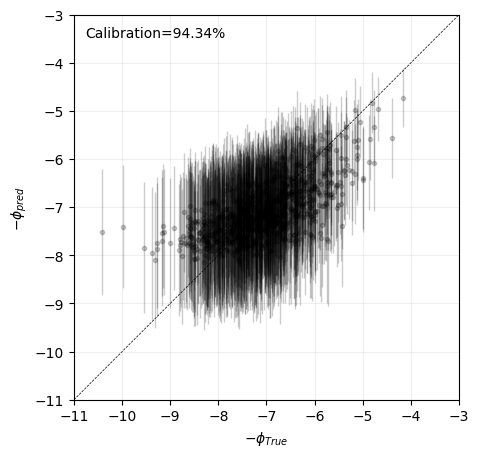

In [17]:
perc = np.mean((predictions['phi_true'] > predictions['ci_95_lower']) & (predictions['phi_true'] < predictions['ci_95_upper'])) * 100
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.errorbar(x=-predictions['phi_true'], y=-predictions['y'], c='black', ms=3,
              yerr=2 * predictions['std'], marker='o', alpha=0.2, lw=0, elinewidth=1)
lim = (-11, -3)
axes.axline((-5, -5), (-6, -6), lw=0.5, c='black', linestyle='--')
axes.set(xlabel=r'$-\phi_{True}$', ylabel=r'$-\phi_{pred}$',
         ylim=lim, xlim=lim, aspect='equal')
axes.text(0.03, 0.97, 'Calibration={:.2f}%'.format(perc), transform=axes.transAxes, va='top')
axes.grid(alpha=0.2)

In this example, we find that the posterior distribution is relatively well approximated by a gaussian, as the Laplace approximation provides well calibrated predictions, as the true generating values lie within the 95% credible interval around 95% of the times. 

<div class="alert alert-block alert-info"><b>Note:</b> Computation of the variance of a single sequence requires solving a large system of equations using iterative methods. While in this small examples we can eaisly compute the posterior variance for every sequence, as the space of possible sequences grows larger, this may become infeasible and the computation of uncertainty may be limited to a reduced number of sequences specified </div>

### How to estimate mutational effects and epistatic coefficients

In many cases, rather than in the individual estimates for individual sequences, we aim to compare a reduced number of sequences e.g. to derive mutational effects and epistatic coefficients. We can obtain the posterior distribution for those comparisons by defining a contrast matrix and using the `make_contrast` method

For instance, if we want to estimate of the effect of an A1T mutation in a AGCGA sequence context, we define a contrast matrix with contrasts on the columns and sequences on rows as follows:

In [18]:
contrast_matrix = pd.DataFrame({'A1T': [1, -1]}, index=['TGCGA', 'AGCGA'])
contrast_matrix

,A1T
TGCGA,1
AGCGA,-1


In [19]:
results = model.make_contrasts(contrast_matrix)
results

100%|██████████| 2/2 [00:00<00:00, 210.19it/s]


,estimate,std,ci_95_lower,ci_95_upper,p(|x|>0)
A1T,-0.22393,0.888807,-2.001543,1.553684,0.599458


Here, we estimate that this mutation most likely has an small effect, but there is a substantial degree of uncertainty, such that it could range from moderately deleterious to moderately beneficial. We may ask now the effect of the same mutation in a different genetic context such as ACTCG

In [20]:
contrast_matrix = pd.DataFrame({'A1T': [1, -1]}, index=['TCTCG', 'ACTCG'])
results = model.make_contrasts(contrast_matrix)
results

100%|██████████| 2/2 [00:00<00:00, 224.65it/s]


,estimate,std,ci_95_lower,ci_95_upper,p(|x|>0)
A1T,-0.036406,0.787761,-1.611928,1.539117,0.51843


Now we can see that this mutation is likely to have a deleterious effect in the ACTCG context. As ACTCG ranks among the most frequently observed sequences, we have more data to support its deleterious effect in this background, which is reflected in a much tighter posterior distribution. 

However, as these posterior distributions may be correlated, to directly compare the effect of this mutation in the two genetic context, we should define an additional contrast

In [21]:
contrast_matrix = pd.DataFrame({'A1T_in_ACTCG_vs_AGCGA': [1, -1, -1, 1]},
                                index=['TCTCG', 'ACTCG', 'TGCGA', 'AGCGA'])
results = model.make_contrasts(contrast_matrix)
results

100%|██████████| 2/2 [00:00<00:00, 357.28it/s]


,estimate,std,ci_95_lower,ci_95_upper,p(|x|>0)
A1T_in_ACTCG_vs_AGCGA,0.187524,1.188433,-2.189341,2.56439,0.562689


Thus, we not only estimate uncertainty of the effects of mutations in specific genetic backgrounds, but also estimate how much the effects of mutations differ across different genetic backgrounds e.g. whether A1T is more deleterious in the ACTCG context than it is in the AGCGA context.

### How to deal with phylogenetically related observations

One of the key assumptions of the original SeqDEFT method is that observations of sequences are completely independent from each other. While this assumption may be reasonable for regulatory elements spread along the genome that have been evolving independently from each other for a long time, such as the 5' splice site or transcription factor binding sites, it is not the case when we are dealing with multiple sequence alignments of homologous proteins across different species.

This is a well known issue in pairwise models, including Potts models used for Direct Coupling Analysis (DCA) and is generally dealt with by re-weighting the observed sequences such that sequences that are closely related to each other take smaller weights. See [Hockenberry and Wilke 2019](https://www.mdpi.com/1099-4300/21/10/1000) for more information. 

#### How to use pre-defined weights from phylogenetic correction

We have implemented the same correction and allow user-defined weights for each of the sequences through the `y` argument using the full length sequences, from which we only select a subset of positions for inference.

In [22]:
positions = np.arange(3)
X_subsequence = get_subsequences(X, positions=positions)
y = calc_msa_weights(X, phylo_correction=True)
model = SeqDEFT(P=2, seq_length=3, alphabet_type='dna')
output = model.fit(X=X_subsequence, y=y)
output

100%|██████████| 115/115 [00:00<00:00, 192.10it/s]


,frequency,phi,Q_star
AAA,0.017442,4.176647,0.015350
AAC,0.009690,4.200178,0.014993
AAG,0.011628,4.176647,0.015350
AAT,0.019380,4.153658,0.015707
ACA,0.011628,4.286995,0.013746
...,...,...,...
TGT,0.021318,4.128529,0.016107
TTA,0.017442,4.090431,0.016732
TTC,0.025194,4.113962,0.016343
TTG,0.023256,4.090431,0.016732


#### How to account for phylogenetic correction during cross-validation

The previous approach allows to have arbitrary weights obtained from any other external means, but variability in the reweighting scheme is not taken into account during cross validation. We can apply the correction separately to training and validation sets by including the full length sequence as input and specifying the positions to take into account and activating the phylogenetic correction option as follows

In [23]:
model.fit(X=X, phylo_correction=True, positions=positions)

,frequency,phi,Q_star
AAA,0.017442,4.176647,0.015350
AAC,0.009690,4.200178,0.014993
AAG,0.011628,4.176647,0.015350
AAT,0.019380,4.153658,0.015707
ACA,0.011628,4.286995,0.013746
...,...,...,...
TGT,0.021318,4.128529,0.016107
TTA,0.017442,4.090431,0.016732
TTC,0.025194,4.113962,0.016343
TTG,0.023256,4.090431,0.016732


Whether the correction is applied before or after splitting the data only has a influence when choosing $a*$ to use with the full data and does not have a strong effect in our experience.

## Inference from real data: 5´splice site

In the previous sections, we have showed how to run SeqDEFT on a small simulated dataset where the true underlying probability distribution is perfectly known. Next, we will show how to run in on a larger dataset and how to reproduce the inference and visualization performed in the original publication ([Chen et al. 2022](https://www.pnas.org/doi/10.1073/pnas.2025782118)) using the set of 5'splice sites extracted from the human genome.

### Data preprocessing

In [24]:
ss = DataSet('5ss')
ss.data
X = ss.data['X'].values

We can see that there is a large number of observations along the human genome. Previous efforts have used pairwise Maximum Entropy models to characterize the splice sites probability distributions along the genome ([Yeo and Burge (2004)](https://pubmed.ncbi.nlm.nih.gov/15285897/)). In what follows, we relax the constrains of this pairwise model to allow variability in the local pairwise epistatic coefficients by specifying `P=2`. To reduce the computational burden and for simplicity, we have previously selected the sequences that have the cannonical GU at positions +1 and +2 and investigate the dependencies on the other positions: -3 to -1 together with +3 to +6.

### Inference with SeqDEFT

In [25]:
model = SeqDEFT(P=2, seq_length=7, alphabet_type='dna')
inferred = model.fit(X=X)

100%|██████████| 115/115 [07:10<00:00,  3.74s/it]


Note that fitting the model for a dataset this large takes a long time. For illustration purposes, we can use the estimated probability distribution from the built-in dataset

In [26]:
inferred

,frequency,phi,Q_star
AAAAAAA,0.000129,8.999252,1.234873e-04
AAAAAAC,0.000058,9.783342,5.637630e-05
AAAAAAG,0.000133,8.953524,1.292653e-04
AAAAAAT,0.000272,8.217149,2.699516e-04
AAAAACA,0.000017,10.881680,1.879727e-05
...,...,...,...
TTTTTGT,0.000010,11.846418,7.163314e-06
TTTTTTA,0.000014,13.704795,1.116944e-06
TTTTTTC,0.000000,14.840094,3.589032e-07
TTTTTTG,0.000003,14.548814,4.802620e-07


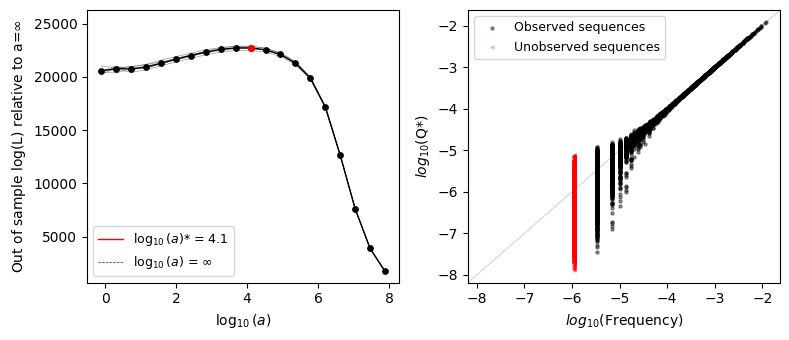

In [27]:
fig = plot.plot_SeqDEFT_summary(model.logL_df, inferred, show_folds=True, legend_loc=3)

We can see how the probability of sequences that have been observed a fair number of times matches their frequency in the dataset, but there is a large variation, of several orders of magnitude in the probability of sequences that have been observed only a few times in the dataset or none at all, as highlithed in red

### Landscape visualization

In [28]:
space = SequenceSpace(X=inferred.index.values, y=np.log(inferred['Q_star']))
print(space)

Sequence Space:
	Type: dna
	Sequence length: 7
	Number of alleles per site: [4, 4, 4, 4, 4, 4, 4]
	Genotypes: [AAAAAAA,AAAAAAC,AAAAAAG,...,TTTTTTC,TTTTTTG,TTTTTTT]
	Function y: [-9.00,-9.78,-8.95,...,-14.84,-14.55,-12.77]


In [29]:
rw = WMWalk(space)
rw.calc_visualization(Ns=1)
ndf, edf = rw.nodes_df, space.get_edges_df()
ndf['2'] = -ndf['2']
ndf['1'] = -ndf['1']
ndf.index = np.array([seq[:3] + 'GT' + seq[3:] for seq in ndf.index])

After generating the coordinates of the visualization and re-inserting the GT sequence at +1 and +2, we can plot the resulting landscape and highlight the sequences that were previously reported to characterize qualitatively different solutions to the 5'splice site recognition ([Chen et al. 2022](https://www.pnas.org/doi/10.1073/pnas.2025782118))

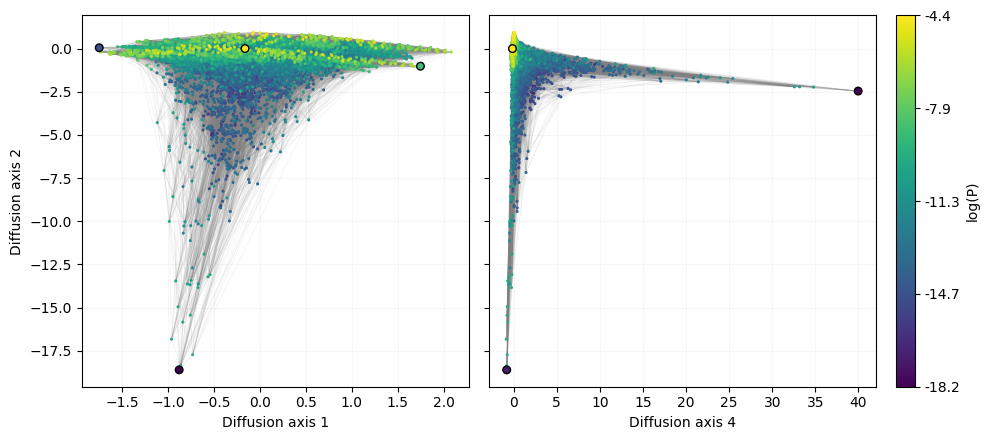

In [30]:
fig, subplots = plt.subplots(1, 3, figsize=(10, 4.5), width_ratios=(0.5, 0.5, 0.025))
cbar_ax = subplots[-1]

axes = subplots[0]
plot.plot_visualization(axes, ndf, edges_df=edf, nodes_size=5,
                        nodes_cmap_label='log(P)', nodes_cbar_axes=cbar_ax)
seqs = ['CAGGTTCAA', 'CAGGTAAGT', 'TCTGTAAGT',
        'ACTGTATCC']
plot.plot_nodes(axes, ndf.loc[seqs, :], size=30, lw=1, edgecolor='black', cbar=False)
axes.grid(alpha=0.1)

axes = subplots[1]
plot.plot_visualization(axes, ndf, edges_df=edf, nodes_size=5, x='4',
                        nodes_cmap_label='log(P)', nodes_cbar=False)
seqs = ['CAGGTAAGT', 'ACTGTATCC',
        'ACAGTTAAG']
plot.plot_nodes(axes, ndf.loc[seqs, :], size=30, lw=1, edgecolor='black', cbar=False, x='4')
axes.set(ylabel='', yticklabels=[])
axes.grid(alpha=0.1)

fig.tight_layout()